In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

2024-07-03 03:51:14.040322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 03:51:14.040480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 03:51:14.301112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Paths to your training and validation CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training and validation data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(str)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(str)

# Load test data CSV
test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(str)

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  # Ensure class_mode is 'binary' and 'y_col' values are strings
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

Found 2412 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.


In [21]:
# Build the model (Using a pre-trained model for transfer learning)
weights_path = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = tf.keras.applications.VGG19(include_top=False, input_shape=(256, 256, 3), weights=weights_path)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 284ms/step - accuracy: 0.6665 - loss: 0.6517 - val_accuracy: 0.8443 - val_loss: 0.3848
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.8588 - loss: 0.3192 - val_accuracy: 0.8566 - val_loss: 0.3599
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.9099 - loss: 0.2360 - val_accuracy: 0.8443 - val_loss: 0.3418
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.9184 - loss: 0.2079 - val_accuracy: 0.8648 - val_loss: 0.3389
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 242ms/step - accuracy: 0.9416 - loss: 0.1650 - val_accuracy: 0.8607 - val_loss: 0.2987
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.9527 - loss: 0.1364 - val_accuracy: 0.8607 - val_loss: 0.2940
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.9579 - loss: 0.1237 - val_accuracy: 0.8607 - val_loss: 0.2979
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.9728 - loss: 0.0970 - val_accu

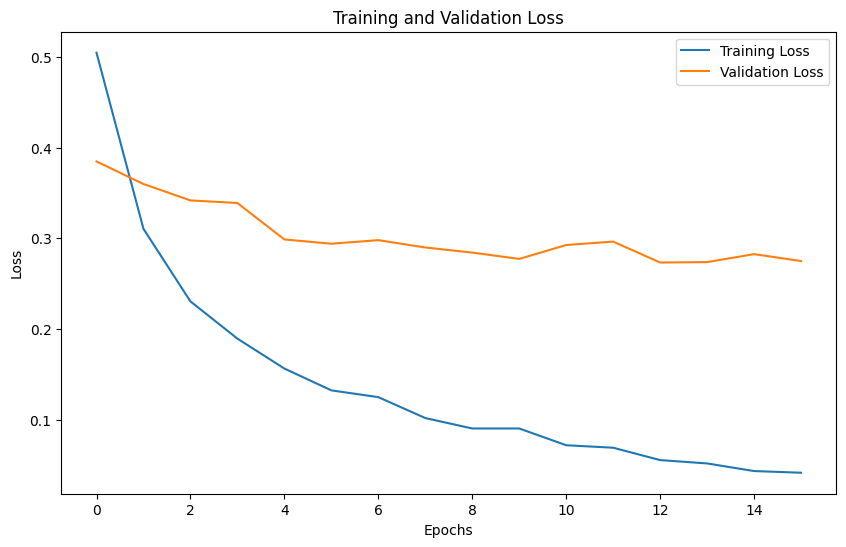

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Save the model
model.save('/kaggle/working/VGG19_model_Mix.h5')

In [25]:
# Evaluate the model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step


Confusion Matrix
[[ 95  14]
 [ 16 119]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.86      0.87      0.86       109
    bleeding       0.89      0.88      0.89       135

    accuracy                           0.88       244
   macro avg       0.88      0.88      0.88       244
weighted avg       0.88      0.88      0.88       244


Class 0 - Non-Bleeding:
Sensitivity: 0.8716
Specificity: 0.8815
True Positive Rate: 0.8716
False Positive Rate: 0.1185

Class 1 - Bleeding:
Sensitivity: 0.8815
Specificity: 0.8716
True Positive Rate: 0.8815
False Positive Rate: 0.1284

ROC Curve Values:
FPR: [0.         0.         0.         0.00917431 0.00917431 0.01834862
 0.01834862 0.02752294 0.02752294 0.03669725 0.03669725 0.04587156
 0.04587156 0.05504587 0.05504587 0.08256881 0.08256881 0.09174312
 0.09174312 0.11009174 0.11009174 0.12844037 0.12844037 0.13761468
 0.13761468 0.1559633  0.1559633  0.17431193 0.17431193 0.18348624
 0.18348624 0.19

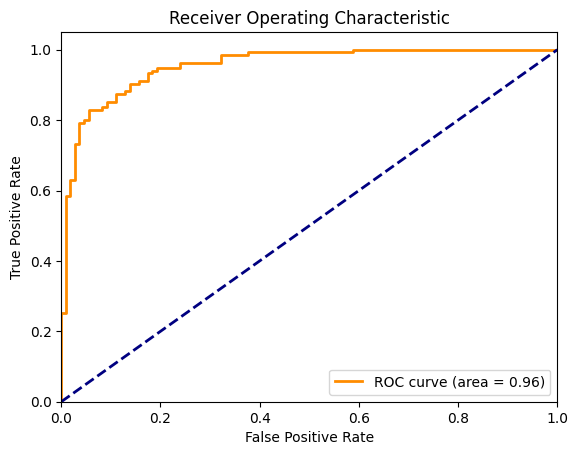

In [26]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [27]:
# Load the previously saved model
model = tf.keras.models.load_model('/kaggle/working/VGG19_model_Mix.h5')

# Evaluate the model on test data
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step


Confusion Matrix
[[301  19]
 [ 14 187]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.96      0.94      0.95       320
    bleeding       0.91      0.93      0.92       201

    accuracy                           0.94       521
   macro avg       0.93      0.94      0.93       521
weighted avg       0.94      0.94      0.94       521


Class 0 - Non-Bleeding:
Sensitivity: 0.9406
Specificity: 0.9303
True Positive Rate: 0.9406
False Positive Rate: 0.0697

Class 1 - Bleeding:
Sensitivity: 0.9303
Specificity: 0.9406
True Positive Rate: 0.9303
False Positive Rate: 0.0594

ROC Curve Values:
FPR: [0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.003125 0.003125 0.00625  0.00625  0.009375 0.009375 0.015625
 0.015625 0.021875 0.021875 0.025    0.025    0.03125  0.03125  0.034375
 0.034375 0.0375   0.0375   0.040625 0.040625 0.04375  0.04375  0.05
 0.05     0.05625  0.05625  0.059375 0.059375 0.0625   0.0625   0.071

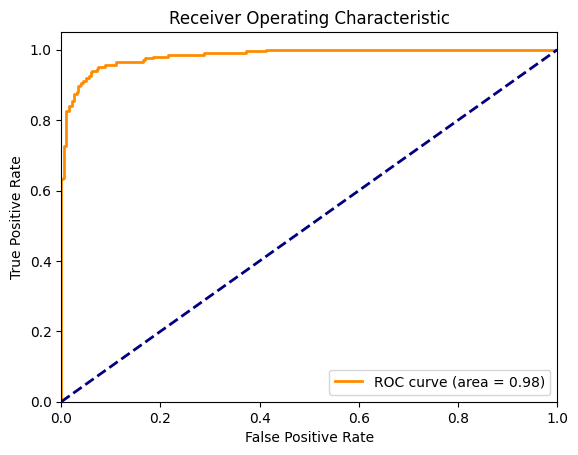

In [28]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()